# CMPE482 Project 1

#### Ali Caner Turkmen

Below we implement the first project assignment, basis regression and autoregressive model using various least squares approaches. 

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def read_data(filepath):
    """
    :returns: numpy.array with (n_items, n_months) shape
    """
    with open(filepath) as f:
        arrs = []
        for line in f.readlines():
            arrs.append(map(float, line.split(" ")))
    return np.array(arrs)

Y = read_data("salesdata.txt")

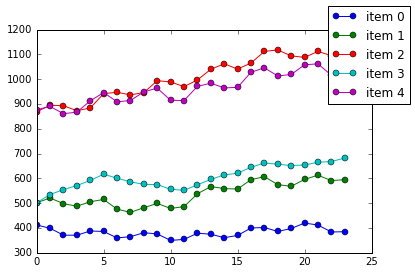

In [3]:
M, N = Y.shape
f = plt.figure()
ax = f.gca()
for i in range(M):
    ax.plot(Y[i, :], "o-", label="item %s" % i)

h, l = ax.get_legend_handles_labels()
f.legend(h, l)

We construct the basis below, for 4, 12, 24 month periods.

In [66]:
def build_basis(N = 24):
    ones = np.ones(N)
    lin  = np.linspace(0, N-1, N)

    trig = lambda x, p: np.c_[np.sin(2*np.pi*lin / p), np.cos(2*np.pi*lin / p)]
    T = np.c_[trig(lin, 4), trig(lin, 12), trig(lin, 24)]

    return np.c_[ones, lin, T]

# Least Squares

Now we implement each least squares method, one by one. Note that we do not implement QR factorization since we had already done that in a previous homework. Here we just want to focus on the least squares problem instead, relying on numpy for calculating the factorizations efficiently and accurately.

In [23]:
import scipy.linalg as spla

In [102]:
class LSSolvers(object):
    def lsq_naive(self, X, y):
        return np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    
    def lsq_normeq(self, X, y):
        Xy = X.T.dot(y)
        XX = X.T.dot(X)
        L = np.linalg.cholesky(XX)  # calculates X = LL^T !
        w = spla.solve_triangular(L, Xy, lower=True)
        return spla.solve_triangular(L.T, w)
    
    def lsq_qr(self, X, y):
        Q, R = np.linalg.qr(X)
        w = Q.T.dot(y)
        return spla.solve_triangular(R, w)
    
    def lsq_svd(self, X, y):
        U, s, V = np.linalg.svd(X, full_matrices=False)
        w = U.T.dot(y) / s
        return V.T.dot(w)
    
    def solve(self, X, y, solver="svd"):
        return getattr(self, "lsq_"+solver)(X,y)

In [103]:
# Let's take a moment to compare their performance first
lss = LSSolvers()
%timeit lss.lsq_naive(X, y)
%timeit lss.lsq_normeq(X, y)
%timeit lss.lsq_qr(X, y)
%timeit lss.lsq_svd(X, y)

The slowest run took 7.23 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 28.2 µs per loop
1000 loops, best of 3: 164 µs per loop
10000 loops, best of 3: 153 µs per loop
10000 loops, best of 3: 50.7 µs per loop


We can now implement the machinery for making predictions. Before moving on, a note on how we interpret the question since it does contain some ambiguities.

The question has two parts. Part one is on solving basis regression for multiple outputs, and writing a function that makes predictions the next N months. Its objective is comparing least squares methods. We don't have to write ALS here. We'll just compare methods.

In the second part, we will pick one of the methods, and write an ALS solver that handles missing data. With that solver, we will also try the AR model.

So the following is part one:

In [104]:
def predict_time_series(Y, nr_months_pred=6, solver="svd"):
    """
    Note that Y = XW can easily be decomposed, when the columns of W are interpreted 
    as the learned regression weights for each time series (columns of Y) separately.
    
    :param Y: the sales data (nr_months_pred, nr_items)
    :param nr_months_pred: the number of months to predict after the data
    """
    n, m = Y.shape
    
    X = build_basis(n + nr_months_pred)
    W = np.zeros((X.shape[1], m))
    lss = LSSolvers()
    
    for j in range(m): # for each item
        W[:, j] = lss.solve(X[:n, :], Y[:,j], solver=solver)
        
    return X[n:, :].dot(W), W

In the below cells, we answer item (3) of the question.

In [145]:
lss = LSSolvers()
preds = {}
for solver in ["naive", "normeq", "qr", "svd"]:
    preds[solver] = predict_time_series(Y.T, 6, solver=solver)

In [146]:
def total_relerr(A, B):
    return np.sum(np.abs(A - B)) / np.sum(np.abs(B))

In [148]:
from __future__ import print_function

keys = preds.keys()

for i in keys:
    print(" "*5, end=" ")
    print(i, end=" ")

print("\n",end="")

for i in preds.keys():
    print(i.ljust(6), end=" ")
    for j in preds.keys():
        print("%.3e" % total_relerr(preds[i], preds[j]), end=" ")
    print("\n", end="")

      naive       qr       svd       normeq 
naive  0.000e+00 6.453e-16 7.537e-16 4.007e-15 
qr     6.453e-16 0.000e+00 3.251e-16 4.252e-15 
svd    7.537e-16 3.251e-16 0.000e+00 4.558e-15 
normeq 4.007e-15 4.252e-15 4.558e-15 0.000e+00 


We observe that QR and SVD are close, but normal equations are off by another order of magnitude. We now wrap this in a function to do the things asked in the question.

In [153]:
def project1(salesdata, testdata=None, nr_months_pred=6, solver="svd"):
    """
    Run a least squares model as required in the assignment
    """
    if testdata is not None:
        nr_months_pred = testdata.shape[0]
        
    w, _ = predict_time_series(salesdata, nr_months_pred, solver="svd")
    
    if testdata is not None:
        for j in range(w.shape[1]):
            print("Item %d: %.4f" % (j, np.linalg.norm(w[:, j] - testdata[:, j])))
            
    return w

Answer to item 5.

In [156]:
project1(Y.T)

array([[  398.43962295,   633.50728676,  1048.53632354,   710.27254869,
         1056.10982156],
       [  386.35447492,   653.6405252 ,  1077.35221848,   746.88893802,
         1070.03303123],
       [  358.57893734,   631.01725399,  1076.31760248,   768.37105119,
         1039.9110287 ],
       [  359.19057805,   620.91576101,  1053.79551944,   785.14142267,
         1046.71755169],
       [  377.94709037,   644.19228316,  1071.75656889,   809.14120867,
         1101.83413901],
       [  370.71707153,   645.98079773,  1119.26273192,   823.46083433,
         1120.93041073]])

And here, we demonstrate the answer to item 4.

In [158]:
salesdata = Y.T[:20, :]
testdata  = Y.T[20:, :]

project1(salesdata, testdata)

Item 0: 3.6838
Item 1: 16.1556
Item 2: 5.8650
Item 3: 16.4204
Item 4: 4.3875


array([[  418.47086632,   592.89915659,  1092.01140031,   654.50062819,
         1056.81724999],
       [  411.11302122,   605.87742911,  1114.82110334,   662.89926594,
         1062.21744336],
       [  384.11094746,   584.18008187,  1098.13970323,   661.29090992,
         1018.82609996],
       [  381.77000744,   582.58440903,  1054.70067629,   667.1691409 ,
         1010.86674691]])

Let's take some time to actually plot the predictions and see if they make any sense. We seem to be doing OK.

In [309]:
preds = project1(Y.T[:20, :], nr_months_pred=4)

In [310]:
np.r_[Y.T[:20,:], preds].shape

(24, 5)

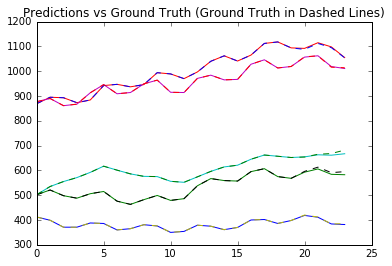

In [312]:
plt.plot(np.r_[Y.T[:20,:], preds])
plt.plot(Y.T, "--")
plt.title("Predictions vs Ground Truth (Ground Truth in Dashed Lines)")

For item 6, we take a different route than suggested in the question. We will unravel the data in time and make a $I \times D_\tau$ matrix for data. We will then learn the weight vector for each item.

In [270]:
def build_ar_data(X, lb=5):
    """
    Take a data set and build AR data with lookback
    """
    # build the lookback data
    A_ = X.copy()
    for i in range(1, lb):
        z = np.empty((i, X.shape[1]))
        z[:] = np.nan

        A_ = np.c_[A_.copy(), np.r_[z, X[:-i, :]]]

    return A_

In [271]:
nandata = read_data("salesdata_nan.txt").T

In [275]:
X_ar = build_ar_data(nandata)[:-1,:]
Y_ar = nandata[1:,:]

To avoid slicing through data, let's re-implement our SVD based least squares solver this time in matrix form. 

In [276]:
def lsq_mat(X, Y):
    U, s, V = np.linalg.svd(X, full_matrices=False)
    w = (U.T.dot(Y).T / s).T
    return V.T.dot(w)

In [277]:
def lsq_mat_right(X, Y):
    """
    Solve least squares of type
    Y = XA where X is unknown
    """
    U, s, V = np.linalg.svd(X, full_matrices=False)
    W = Y.dot(V.T) / s
    return W.dot(U.T)

Now we write alternating least squares that handles missing data

In [278]:
def als(X, Y):
    """
    Solve alternating least squares of type
    Y = XW 
    
    """
    nanX = np.nonzero(np.isnan(X))
    nanY = np.nonzero(np.isnan(Y))
    
    X = np.nan_to_num(X)
    Y = np.nan_to_num(Y)
    
    W = np.random.rand(X.shape[1], Y.shape[1])
    
    prevX = X.copy()
    prevW = W.copy()
    
    conv = [], []
    
    for i in range(100):
        W = lsq_mat(X, Y)
        X[nanX] = lsq_mat_right(W, Y)[nanX]
        Y[nanY] = X.dot(W)[nanY]
        
        diffX = np.linalg.norm(X - prevX, "fro")
        diffW = np.linalg.norm(W - prevW, "fro")
        
        conv[0].append(diffX)
        conv[1].append(diffW)
        
        if diffX < 1e-8 and diffW < 1e-8:
            break
        
        prevX = X.copy()
        prevW = W.copy()
    
    return W, conv

Below we run the ALS algorithm and check it converges.

In [281]:
W, c = als(X_ar, Y_ar)

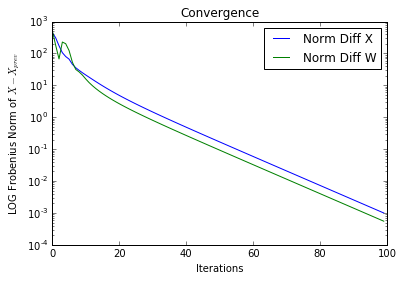

In [282]:
plt.plot(c[0], label="Norm Diff X")
plt.plot(c[1], label="Norm Diff W")
plt.title("Convergence")
plt.xlabel("Iterations")
plt.ylabel("LOG Frobenius Norm of $X - X_{prev}$")
plt.semilogy()
plt.legend()

Finally, we wrap the above code in a function in coherence with the project requirements.

In [296]:
def project_part2(D_tau, salesdata, testdata=None):
    
    X = build_ar_data(salesdata, lb=D_tau)[:-1, :]
    Y = salesdata[1:,:]
    
    W, cg = als(X, Y)
    
    y_pred = (W.T.dot(np.nan_to_num(X[-1,:]))).T
    
    if testdata is not None:
        X_test = build_ar_data(testdata, lb=D_tau)[:-1, :]
        Y_test = testdata[1:, :]
        
        print("Test error: ", np.linalg.norm(Y_test - np.nan_to_num(X_test.dot(W)), "fro"))
    
#     W__ = 
    return W, y_pred

First we check for the no NaN scenario and make predictions and tests.

In [297]:
project_part2(5, salesdata, testdata)

Test error:  3103.68394009


(array([[  1.07193410e+00,   7.70843769e-01,   2.58848973e+00,
           1.02742658e+00,   2.79283570e+00],
        [ -4.09431229e-01,  -7.62916019e-02,  -2.73740204e-01,
           5.57996860e-02,  -3.97571571e-01],
        [  1.50018853e-01,  -6.20007461e-01,  -8.35560879e-02,
          -5.14917460e-01,  -4.61105267e-01],
        [ -2.03339566e-01,  -1.61634690e-03,  -5.28913802e-02,
           2.19368213e-01,   2.31032563e-01],
        [ -3.05652231e-01,   3.19177397e-01,  -9.82244079e-01,
          -1.37999862e-01,  -7.94067102e-01],
        [  1.39589500e-01,   4.90711132e-02,  -4.45348379e-02,
           2.73075249e-03,   1.64683794e-02],
        [  4.60753753e-01,   7.73159088e-01,   1.59951616e+00,
           9.92819514e-01,   1.33490577e+00],
        [ -2.22654045e-01,   1.01416469e-01,  -8.89911873e-01,
          -2.47157295e-01,  -4.04693902e-01],
        [  1.38591132e+00,   1.47419939e+00,   3.09487320e+00,
           1.36991436e+00,   3.12339801e+00],
        [ -6.007460

We can also now check that everything works fine with NaNs.

In [298]:
project_part2(5, nandata)

(array([[  5.45394841e-01,  -1.07189476e-01,  -2.39490084e-01,
          -6.64143285e-01,  -3.88104035e+01],
        [ -5.97831802e-03,   5.25903893e-01,  -2.65292885e-02,
          -2.81549581e-01,   6.54050071e+01],
        [  4.62462848e-01,  -3.93551757e-01,   9.47833428e-01,
           3.94825916e+00,  -4.07811928e+01],
        [ -3.71977677e-01,  -1.34394379e-01,  -7.44803669e-01,
          -2.95219054e+00,  -2.01620006e+01],
        [ -1.80229725e-04,  -5.15274072e-04,  -3.47717868e-03,
          -1.56087205e-02,  -1.99146279e+00],
        [  1.19049024e+00,   2.43251379e-01,  -2.35088042e-01,
          -8.54629527e-01,  -2.19318342e+01],
        [ -2.89461821e+00,  -8.01431091e-01,   1.46332525e+00,
           5.52904309e+00,   7.16318268e+01],
        [ -3.66598737e-01,  -2.66534517e-01,  -6.99162662e-01,
          -1.68797244e+00,   1.59551716e+01],
        [  2.38677989e-01,   1.05740792e-01,  -2.77070546e-01,
          -2.42570803e+00,  -1.11454780e+01],
        [  1.064764